In [1]:
from matplotlib import pyplot as plt
from PIL import Image
from matplotlib.image import imread
import numpy as np
import os
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import DensityMatrix, SparsePauliOp
from qiskit.circuit.library import QFT
from qiskit.synthesis import SuzukiTrotter
from qiskit.circuit.library import PauliEvolutionGate
import numpy as np
import math

Set file locations and size of images

In [2]:
#TRAIN_IMG_FOLDER = './ReducedFaces/training/'
#TEST_IMG_FOLDER = './ReducedFaces/testing/'
#TRAIN_IMG_FOLDER = './Faces/training/'
#TEST_IMG_FOLDER = './Faces/testing/'
TRAIN_IMG_FOLDER = './PCA-Based-Face-Recognition/images1/Training images/'
TEST_IMG_FOLDER = './PCA-Based-Face-Recognition/images1/Test/'

train_set_files = os.listdir(TRAIN_IMG_FOLDER)
test_set_files = os.listdir(TEST_IMG_FOLDER)

width  = 256
height = 256

Load data and convert the images into tensors

In [3]:
train_image_names = os.listdir(TRAIN_IMG_FOLDER)
training_tensor   = np.ndarray(shape=(len(train_image_names), height*width), dtype=np.float64)
print('Number of training images:', len(train_image_names))

for i in range(len(train_image_names)):
    img = Image.open(TRAIN_IMG_FOLDER + train_image_names[i]).convert('L')
    img = img.resize((width, height))
    training_tensor[i,:] = np.array(img, dtype='float64').flatten()

test_image_names = os.listdir(TEST_IMG_FOLDER)
testing_tensor   = np.ndarray(shape=(len(test_image_names), height*width), dtype=np.float64)
print('Number of test images:', len(test_image_names))

for i in range(len(test_image_names)):
    img = Image.open(TEST_IMG_FOLDER + test_image_names[i]).convert('L')
    img = img.resize((width, height))
    testing_tensor[i,:] = np.array(img, dtype='float64').flatten()

Number of training images: 25
Number of test images: 40


Calculate the mean face

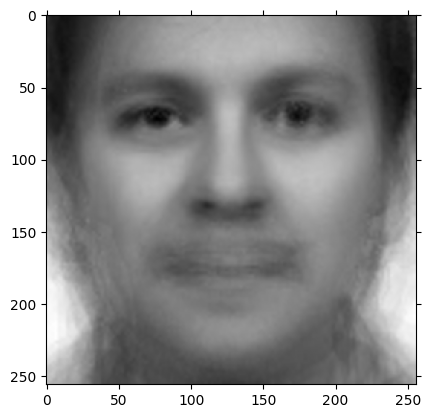

In [16]:
mean_face = np.zeros((1,height*width))

for i in training_tensor:
    mean_face = np.add(mean_face,i)

mean_face = np.divide(mean_face,float(len(train_image_names))).flatten()

plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
plt.show()

Create the covariance matrix using the training images tensor

In [17]:
normalised_training_tensor = np.ndarray(shape=(len(train_image_names), height*width))

for i in range(len(train_image_names)):
    normalised_training_tensor[i] = np.subtract(training_tensor[i], mean_face)
normalised_training_tensor


cov_matrix = np.cov(normalised_training_tensor)
cov_matrix = np.divide(cov_matrix, len(train_image_names)*1.0)
#print(np.dot(Q.T, Q).round(12)) verify that the matrix is hermitian
print('Covariance Matrix Shape:', cov_matrix.shape)

Covariance Matrix Shape: (25, 25)


Calculate the number of qubits needed for QPCA

In [18]:
def calculate_phase_qubits(cov_matrix):
    shape1 = cov_matrix.shape[0]
    shape2 = cov_matrix.shape[1]
    if shape1 > shape2:
        shape = shape1
    else:   
        shape = shape2
    required_qubits = math.ceil(math.log2(shape))
    return required_qubits
    
phase_qubits = calculate_phase_qubits(cov_matrix)
print(f"Phase register qubits needed: {phase_qubits}")

Phase register qubits needed: 5


Create the density matrix. Pad the density matrix with 0's if the size of the density matrix is less than the size of the Hilbert space.

Also ensures that the density matrix is a 2^n x 2^n matrix.

In [19]:
def density_matrix_encoding(data, nqubits):
    rho = data / np.trace(data)
    target_dim = 2**nqubits
    # Pad the density matrix with zeros
    padded_rho = np.zeros((target_dim, target_dim), dtype=complex)
    padded_rho[:rho.shape[0], :rho.shape[1]] = rho
    rho = padded_rho
    return rho

rho = density_matrix_encoding(cov_matrix, phase_qubits)
rho.shape

(32, 32)

#### Implement QPE

In [20]:
def qpca_eigenvectors(rho, num_phase_qubits, evolution_time=1.0, trotter_steps=2):
    """
    Args:
        rho (DensityMatrix): Input density matrix (2^m x 2^m).
        num_phase_qubits (int): Number of qubits in the phase register.
        evolution_time (float): Time parameter for Hamiltonian simulation.
        trotter_steps (int): Number of Trotter steps (higher = more accurate).
    
    Returns:
        dict: Estimated eigenvalues (keys) and eigenvectors (values).
    """
    print("Initializing QPCA circuit...")
    m = int(np.log2(len(rho)))  # Number of qubits for the data register
    print("Number of qubits in the data register:", m)
    total_qubits = num_phase_qubits + m
    qpe_circuit = QuantumCircuit(total_qubits)
    
    ### Step 1: Decompose ρ into Pauli strings ###
    # Convert ρ to a SparsePauliOp (efficient for large systems)
    pauli_op = SparsePauliOp.from_operator(DensityMatrix(rho))
    
    ### Step 2: Construct QPE circuit with Trotterized U = e^{-iρt} ###
    qpe_circuit.h(range(num_phase_qubits))
    
    print("Trotterizing Hamiltonian...")
    # Trotterized controlled-U operations
    for qubit in range(num_phase_qubits):
        exponent = 2 ** qubit
        # Create evolution gate with SuzukiTrotter
        evolution_gate = PauliEvolutionGate(
            pauli_op * (evolution_time * exponent),
            time=1.0,
            synthesis=SuzukiTrotter(order=2, reps=trotter_steps)
        )
        
        # Convert to controlled gate and apply
        cU = evolution_gate.control(1)
        qpe_circuit.append(cU, [qubit] + list(range(num_phase_qubits, total_qubits)))
    
    print("Applying inverse QFT...")
    # Inverse QFT
    qpe_circuit.append(QFT(num_phase_qubits, inverse=True), range(num_phase_qubits))
    
    ### Step 3: Run QPE and post-process ###
    print("Running QPE...")
    qpe_circuit.save_statevector()
    backend = AerSimulator(method='statevector')
    transpiled = transpile(qpe_circuit, backend)
    result = backend.run(transpiled).result()
    statevector = result.get_statevector(qpe_circuit)
    # Reshape the statevector to correspond to a phase register basis state and each column to a data register basis state
    statevector = np.array(statevector).reshape((2**num_phase_qubits, 2**m))

    print("Post-processing results...")
    eigenvalues = []
    eigenvectors = []
    for i in range(2**num_phase_qubits):
        eigenvector = statevector[i, :]
        if not np.allclose(eigenvector, 0):
            lambda_j = i / (2**num_phase_qubits)  # Estimate eigenvalue (phase)
            eigenvalues.append(lambda_j)
            eigenvectors.append(eigenvector / np.linalg.norm(eigenvector))  # Normalize

    # Convert to np.linalg.eig() format
    eigenvalues_np = np.array(eigenvalues, dtype=complex)
    eigenvectors_np = np.column_stack(eigenvectors)

    return eigenvalues_np, eigenvectors_np, qpe_circuit

eigenvalues, eigenvectors, qpe_circuit = qpca_eigenvectors(rho, num_phase_qubits=phase_qubits, trotter_steps=2) #5-10 minutes

Initializing QPCA circuit...
Number of qubits in the data register: 5
Trotterizing Hamiltonian...
Applying inverse QFT...
Running QPE...
Post-processing results...


Sort Eigenvalues by descending order

In [21]:
N = len(train_image_names)
# Get indices that would sort eigenvalues in descending order
sorted_ind = sorted(range(0, N), key=lambda k: eigenvalues[k], reverse=True)

# Take the first N sorted eigenvalues and eigenvectors
eigvalues_sort = eigenvalues[sorted_ind]
eigvectors_sort = []
for i in sorted_ind:
    eigenvectors_sort_b = []
    for j in sorted_ind:
        a = eigenvectors[i, j]
        eigenvectors_sort_b.append(a)
    eigvectors_sort.append(eigenvectors_sort_b)

train_set_files_sort = np.array(train_set_files)[sorted_ind]

Show cumulative proportion of varaince with respect to components

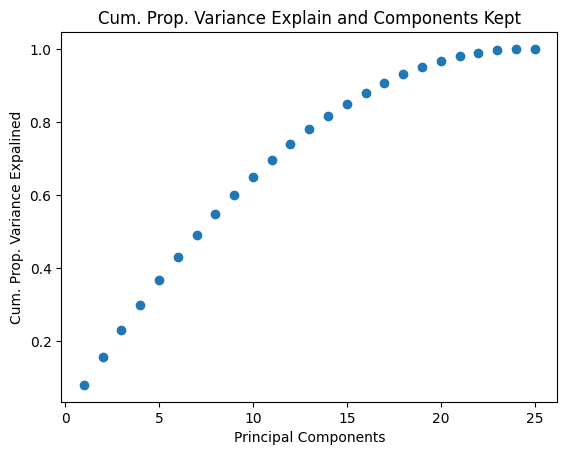

In [22]:
var_comp_sum = np.cumsum(eigvalues_sort)/sum(eigvalues_sort)

# x-axis for number of principal components kept
num_comp = range(1,len(eigvalues_sort)+1)
plt.title('Cum. Prop. Variance Explain and Components Kept')
plt.xlabel('Principal Components')
plt.ylabel('Cum. Prop. Variance Expalined')

plt.scatter(num_comp, var_comp_sum)
plt.show()

Calculate eigenfaces and the weights for each eigenface

In [23]:
reduced_data = np.array(eigvectors_sort).transpose()
print(training_tensor.transpose().shape, reduced_data.shape)
proj_data = np.dot(training_tensor.transpose(), reduced_data)
proj_data = proj_data.transpose()
#w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
#print(w.shape)

(65536, 25) (25, 25)


In [24]:
w = np.array([np.dot(proj_data,i) for i in normalised_training_tensor])
print(w.shape)

(25, 25)


In [25]:
def recogniser(test_image_names, train_image_names, proj_data, w, t0, prn=False):
    count        = 0
    num_images   = 0
    correct_pred = 0
    result = []
    wts = []
    
    #False match rate (FMR)
    FMR_count = 0
    #False non-match rate (FNMR)
    FNMR_count = 0
    
    test_image_names2 = sorted(test_image_names)

    for img in test_image_names2:
        #unknown_face = plt.imread(TEST_IMG_FOLDER+img)
        unknown_face = Image.open(TEST_IMG_FOLDER + img).convert('L')
        unknown_face = unknown_face.resize((width, height))
        num_images += 1
        
        unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
        normalised_uface_vector = np.subtract(unknown_face_vector, mean_face)

        w_unknown = np.dot(proj_data, normalised_uface_vector)
        diff  = w - w_unknown
        norms = np.linalg.norm(diff, axis=1)
        index = np.argmin(norms)
        
        wts.append([count, norms[index]])

        if prn: print('Input:'+'.'.join(img.split('.')[:2]), end='\t')
        count+=1
        
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        if norms[index] < t0: # It's a face
            if match:
                if prn: print('Matched:' + train_image_names[index], end = '\t')
                correct_pred += 1
                result.append(1)
            else:
                if prn: print('F/Matched:' + train_image_names[index], end = '\t')
                result.append(0)
                FMR_count += 1
        else:
            if match:
                if prn: print('Unknown face!: ' + train_image_names[index], end = '\t')
                FNMR_count +=1
                
            else:
                pass
                correct_pred += 1

        if prn: print(norms[index], end=' ')
        if prn: print()

    FMR = FMR_count/num_images
    FNMR = FNMR_count/num_images
    
    
    print('Correct predictions: {}/{} = {} \t\t'.format(correct_pred, num_images, correct_pred/num_images), end=' ')
    print('FMR: {} \t'.format(FMR), end=' ')
    print('FNMR: {} \t'.format(FNMR))
    
    return wts, result, correct_pred, num_images, FMR, FNMR
    
wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data, w, t0=2e7, prn=True)

Input:00770_960530_fa.jpg	Matched:00770_960530_fa.jpg	0.0 
Input:00770_960530_fa_a.jpg	97190526.55993412 
Input:00771_941205_fa.jpg	Matched:00771_941205_fa.jpg	0.0 
Input:00771_941205_fb.jpg	60757363.50162327 
Input:00772_941201_fa.jpg	Matched:00772_941201_fa.jpg	0.0 
Input:00772_941201_fb.jpg	34072835.83860219 
Input:00773_941201_fa.jpg	Matched:00773_941201_fa.jpg	0.0 
Input:00773_941201_fb.jpg	47503702.60012078 
Input:00775_941205_fa.jpg	Matched:00775_941205_fa.jpg	0.0 
Input:00775_941205_fb.jpg	Matched:00775_941205_fa.jpg	7676823.488764704 
Input:00779_941205_fa.jpg	Matched:00779_941205_fa.jpg	0.0 
Input:00779_941205_fb.jpg	79378950.69226766 
Input:00781_941205_fa.jpg	Matched:00781_941205_fa.jpg	0.0 
Input:00781_941205_fb.jpg	23658816.154597428 
Input:00787_941205_fa.jpg	Matched:00787_941205_fa.jpg	0.0 
Input:00787_941205_fb.jpg	101576532.85595223 
Input:00794_941205_fa.jpg	Matched:00794_941205_fa.jpg	0.0 
Input:00794_941205_fb.jpg	50761507.049413376 
Input:00797_941205_fa.jpg	Match

In [26]:
CPR_list, t0_list, FMR_list, FNMR_list = [], [] , [] , []
for t0 in np.linspace(start=0, stop=2e7, num=20):
    print('{:e}'.format(t0), end=' ')
    wts, result, correct_pred, num_images, FMR, FNMR = recogniser(test_image_names, train_image_names,proj_data, w, t0)
    
    CPR_list.append(correct_pred/num_images) 
    t0_list.append(t0)
    FMR_list.append(FMR)
    FNMR_list.append(FNMR)

0.000000e+00 Correct predictions: 25/40 = 0.625 		 FMR: 0.0 	 FNMR: 0.375 	
1.052632e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
2.105263e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
3.157895e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
4.210526e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
5.263158e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
6.315789e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
7.368421e+06 Correct predictions: 38/40 = 0.95 		 FMR: 0.0 	 FNMR: 0.05 	
8.421053e+06 Correct predictions: 39/40 = 0.975 		 FMR: 0.0 	 FNMR: 0.025 	
9.473684e+06 Correct predictions: 39/40 = 0.975 		 FMR: 0.0 	 FNMR: 0.025 	
1.052632e+07 Correct predictions: 39/40 = 0.975 		 FMR: 0.0 	 FNMR: 0.025 	
1.157895e+07 Correct predictions: 39/40 = 0.975 		 FMR: 0.0 	 FNMR: 0.025 	
1.263158e+07 Correct predictions: 39/40 = 0.975 		 FMR: 0.0 	 FNMR: 0.025 	
1.368421e+07 Correct predi

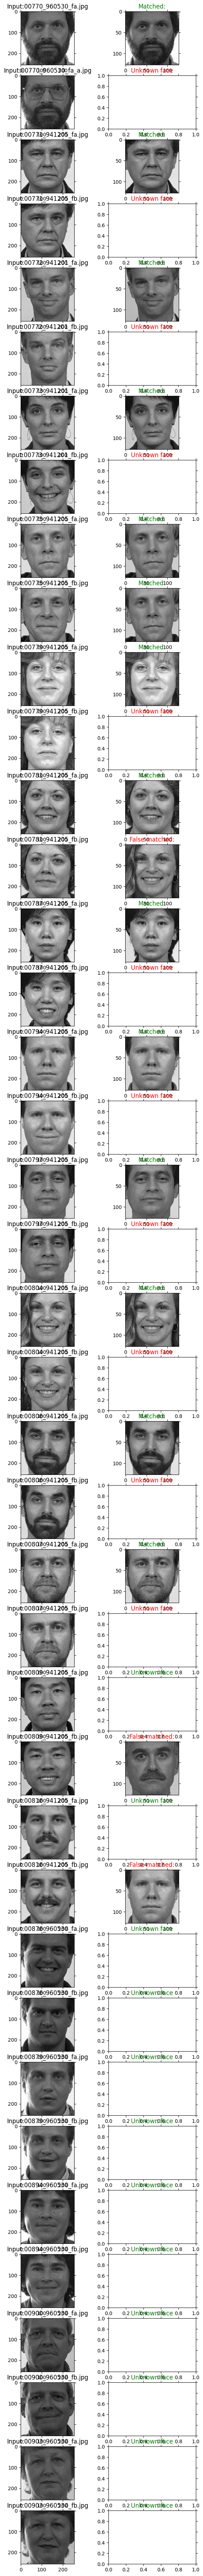

In [27]:
count        = 0
num_images   = 0
correct_pred = 0
def Visualization(img, train_image_names,proj_data,w, t0):
    global count,highest_min,num_images,correct_pred
    #unknown_face        = plt.imread(TEST_IMG_FOLDER+img)
    unknown_face = Image.open(TEST_IMG_FOLDER + img).convert('L')
    unknown_face = unknown_face.resize((width, height))
    num_images          += 1
    unknown_face_vector = np.array(unknown_face, dtype='float64').flatten()
    normalised_uface_vector = np.subtract(unknown_face_vector,mean_face)
    
    plt.subplot(40,2,1+count)
    plt.imshow(unknown_face, cmap='gray')
    plt.title('Input:'+'.'.join(img.split('.')[:2]))
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    count+=1
    
    w_unknown = np.dot(proj_data, normalised_uface_vector)
    diff  = w - w_unknown
    norms = np.linalg.norm(diff, axis=1)
    index = np.argmin(norms)
    
    plt.subplot(40,2,1+count)
    if norms[index] < t0: # It's a face
            
        match = img.split('_')[0] == train_image_names[index].split('_')[0]
        #if img.split('.')[0] == train_image_names[index].split('.')[0]:
        if match:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='g')
            plt.title('Matched:', color='g')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
                
            correct_pred += 1
        else:
            #plt.title('Matched:'+'.'.join(train_image_names[index].split('.')[:2]), color='r')
            plt.title('False matched:', color='r')
            plt.imshow(imread(TRAIN_IMG_FOLDER+train_image_names[index]), cmap='gray')
    else:
        #if img.split('.')[0] not in [i.split('.')[0] for i in train_image_names] and img.split('.')[0] != 'apple':
        if img.split('_')[0] not in [i.split('_')[0] for i in train_image_names]:
            plt.title('Unknown face', color='g')
            correct_pred += 1
        else:
            plt.title('Unknown face', color='r')
                
    plt.tick_params(labelleft='off', labelbottom='off', bottom='off',top='off',right='off',left='off', which='both')
    plt.subplots_adjust(right=1.2, top=2.5)
   
    count+=1

    
fig = plt.figure(figsize=(5, 30))

test_image_names2 = sorted(test_image_names)
for i in range(len(test_image_names2)):
    Visualization(test_image_names2[i], train_image_names,proj_data,w, t0=2.7e7)

plt.show()